In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
stop_words = stopwords.words('spanish')+list(STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ajburri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("og_dataset.csv", index_col = 0)
df.head()

,sentence,sentiment
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra
1,Internacional de Porto Alegre habría llegado a...,Neutra
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva
3,Estoy triste quiero tatuarme,Negativa
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa


In [3]:
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 23132 entries, 0 to 23132
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   23132 non-null  object
 1   sentiment  23132 non-null  object
dtypes: object(2)
memory usage: 542.2+ KB
None

(23132, 2)


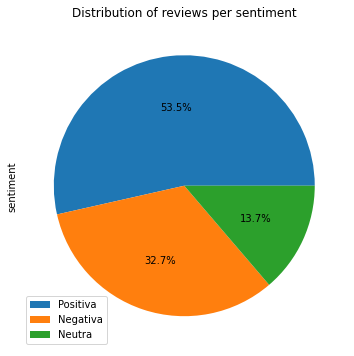

In [4]:
print(df.info())
print("")
print(df.shape)
df['sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['','',''],autopct='%1.1f%%')
labels=["Positiva","Negativa","Neutra"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

In [5]:
def only_words(sentence):
    url_reg = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_reg = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_reg = re.compile(r'[ ]{2,}')
    
    try:
      result = url_reg.sub('', sentence)
    except Exception as e:
      print(sentence)
    result = html_reg.sub('', result)
    result = spaces_reg.sub('', result)
    result = re.findall(r'\w+', result)
    result = [''.join(x for x in i if x.isalpha()) for i in result]
    result = ' '.join(result)
    
    return result

In [6]:
nlp = spacy.load('es_core_news_md')

def remove_stop_words(sentence):
    result = ""
    if sentence != None:
        sentence = sentence.split(" ")
        result = list(
        filter(lambda l: (l not in stop_words and len(l) > 2), sentence))
        result = ' '.join(result)
    return result

In [7]:
def lematize(sentence):
    doc = nlp(sentence)
    result = ""
    i = 1
    for token in doc:
        if i == len(doc):
            result += token.lemma_
        else:
            result += token.lemma_ + " "
        i+=1
    return result

In [8]:
def remove_accents(sentence):
    replacements = {
        "á" : "a",
        "é" : "e",
        "í" : "i",
        "ó" : "o",
        "ú" : "u",
    }
    for i,j in replacements.items():
        sentence = sentence.replace (i,j)
    return sentence

In [9]:
def tokenize(dataframe):
    data = dataframe.copy()
    data['tokens'] = data['sentence'].str.lower()
    data['tokens'] = data['tokens'].apply(only_words)
    data['tokens'] = data['tokens'].apply(remove_stop_words)
    data['tokens'] = data['tokens'].apply(lematize)
    data['tokens'] = data['tokens'].apply(remove_accents)
    return data

In [10]:
df = tokenize(df)
df.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre llegado fichar mart...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste


In [11]:
codes = {
    'Positiva': 1,
    'Neutra': 0,
    'Negativa' : -1
}
df['sentiment_code'] = df['sentiment']
df = df.replace({'sentiment_code' : codes})
df.head()

,sentence,sentiment,tokens,sentiment_code
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...,0
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre llegado fichar mart...,0
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr,1
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo,-1
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste,-1


In [12]:
df.to_csv("og_tokenized.csv")

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['tokens'],
                                                    df['sentiment_code'],
                                                    test_size=0.10)

In [14]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

In [15]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

In [16]:
with open('tfidf.pickle', 'wb') as file_tfidf:
    pickle.dump(tfidf, file_tfidf)

In [17]:
rfc = RandomForestClassifier()
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [10,50,100],
}

In [19]:
gridsearch = GridSearchCV(estimator = rfc,
                          param_grid = params,
                          cv = 2,
                          n_jobs = 1)

gridsearch.fit(features_train, labels_train)
print(gridsearch.best_params_)
print(gridsearch.cv_results_['mean_test_score'])


{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
[0.6615429  0.67148621 0.67182246 0.65966952 0.66927659 0.67081372
 0.66120665 0.67864348 0.68022865 0.66043808 0.66946873 0.67143818
 0.66231146 0.66903641 0.67167836 0.66437698 0.67638582 0.68022865]


In [26]:
rfc = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_features= 'log2', n_estimators= 100)
rfc.fit(features_train, labels_train)

RandomForestClassifier(max_features='log2')

In [27]:
prediction = rfc.predict(features_test)
print(rfc.score(features_test, labels_test))

0.7057044079515989


In [28]:
with open('rfc.pickle', 'wb') as file_rfc:
    pickle.dump(rfc, file_rfc)